In [1]:
%load_ext autoreload
%autoreload 2
_ = !pip3 install matplotlib einops ema-pytorch
%matplotlib inline

from multiprocessing import cpu_count
import numpy as np
import torch
from torch import nn
from torch.utils.data import DataLoader, ConcatDataset
import torchvision
from torchvision.datasets import CIFAR10
from torchvision.transforms import ToTensor, Compose, CenterCrop, Normalize, RandomHorizontalFlip
from tqdm.notebook import tqdm
from matplotlib import pyplot as plt

dev = 'cuda' if torch.cuda.is_available() else 'cpu'
dev

'cuda'

In [2]:
train_set = CIFAR10('./dataset', train=True, transform=Compose([
        RandomHorizontalFlip(),
        #CenterCrop((128, 128)),
        ToTensor(),
        Normalize(.5, .5),
    ]), download=True)

test_set = CIFAR10('./dataset', train=False, transform=Compose([
        RandomHorizontalFlip(),
        #CenterCrop((128, 128)),
        ToTensor(),
        Normalize(.5, .5),
    ]), download=True)

dataset = ConcatDataset([train_set, test_set])

Files already downloaded and verified
Files already downloaded and verified


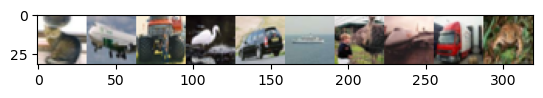

In [3]:
def showimgs(imgs):
    #plt.figure(figsize=(20, 10))
    imgs = imgs.movedim((0, 2, 3, 1), (0, 1, 2, 3))
    imgs = np.concatenate(imgs.detach().cpu().numpy().tolist(), axis=1)
    imgs = (imgs + 1)/2
    np.clip(imgs, 0, 1)
    plt.imshow(imgs)


#img, label = train_set[np.random.randint(0, len(train_set))]

BS = 64
loader = DataLoader(dataset, batch_size=BS, num_workers=cpu_count(), shuffle=True)
batch, _ = next(iter(loader))
showimgs(batch[:10])

In [4]:
from model import DenoisingDiffusion
import os

def get_model():
    model = DenoisingDiffusion(
        lr=2e-4,
        channels=[64, 128, 256],
        diffusion_steps=1000,
        dropout_rate=0.1,
        dev=dev
    )
    try:
        chks = os.listdir('./chkpnts')
        ns = [int(chk.split('checkpnt_step-')[1].split('k.pt')[0])
             for chk in chks]
        if len(ns) == 0:
            raise Exception('No checkpoints in ./chkpnts')
        n = sorted(ns)[-1]
        print(f'checkpnt_epoch-{n}.pt')
        model.load(f'chkpnts/checkpnt_step-{n}k.pt')

    except Exception as e:
        print(e)
    return model

model = get_model()
print(f'{sum([p.numel() for p in model.parameters()]):,}')

checkpnt_epoch-1110.pt
38,230,662


  0%|          | 0/1000 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


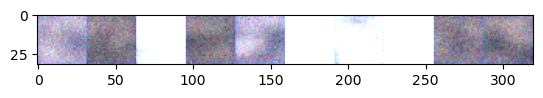

In [5]:
model.eval()
img = model.backward_process(torch.randn((10, 3, 32, 32)).to(dev), ema=False, tqdm=True).cpu()
showimgs(img)

In [ ]:
model.train_loop(1_700_000, loader)

 65%|######5   | 1110000/1700000 [00:00<?, ?it/s]